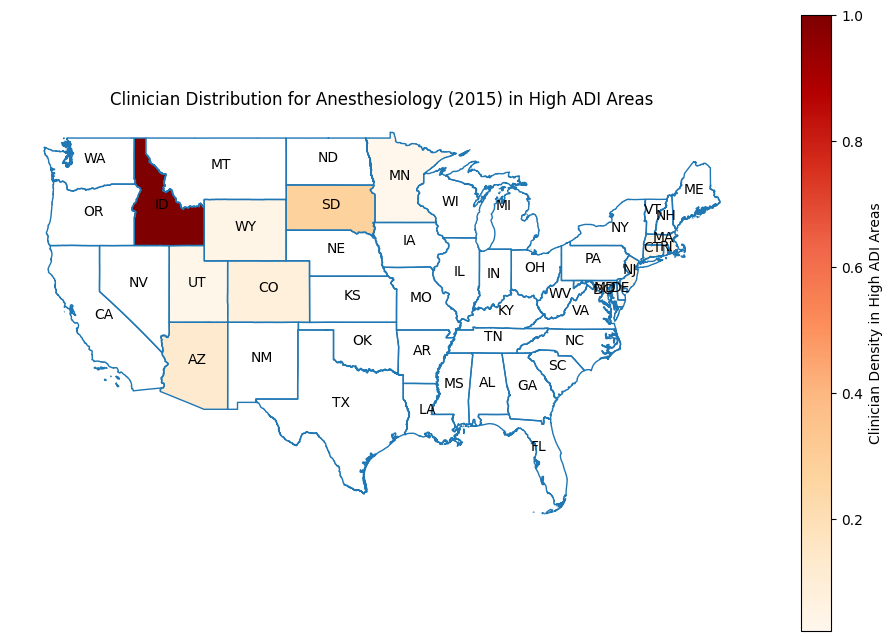

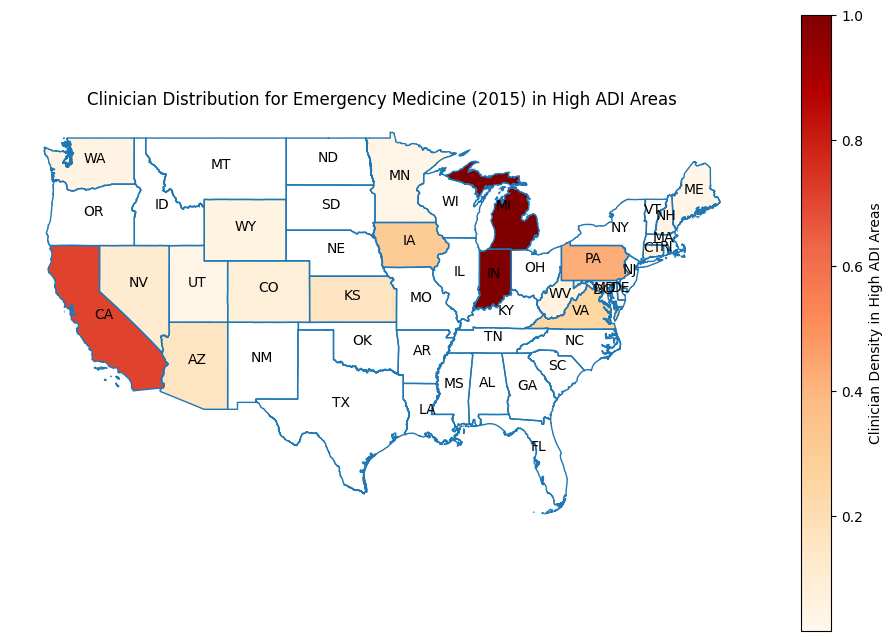

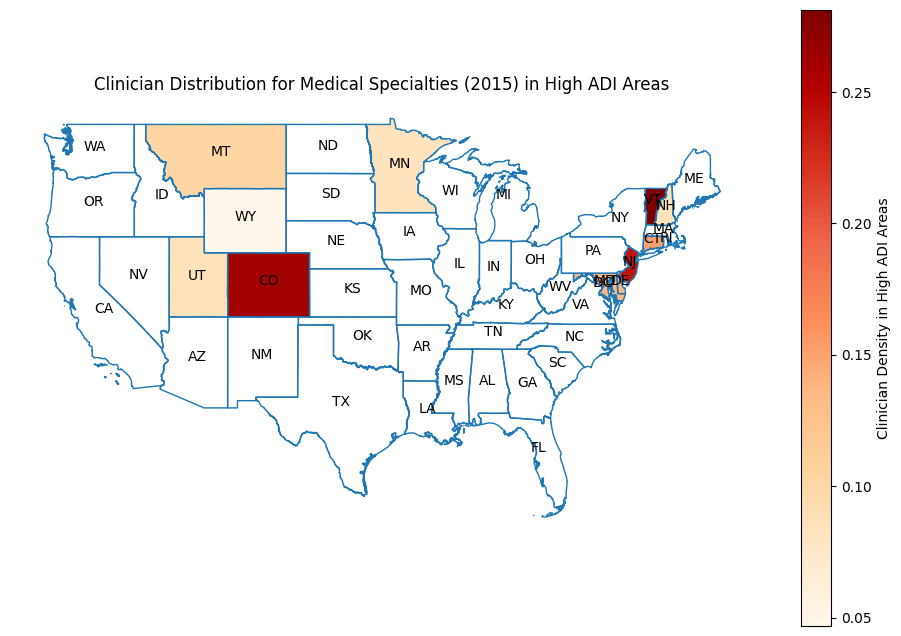

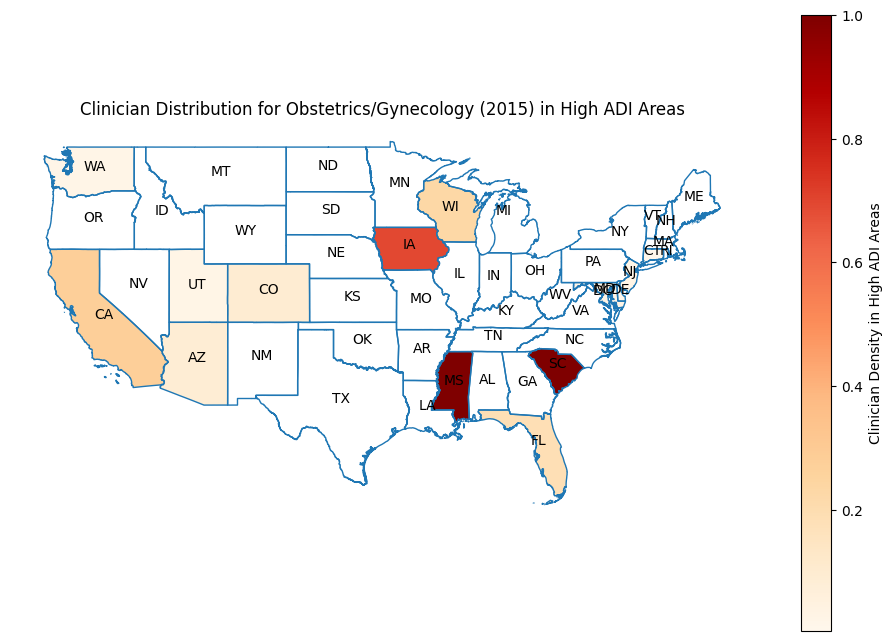

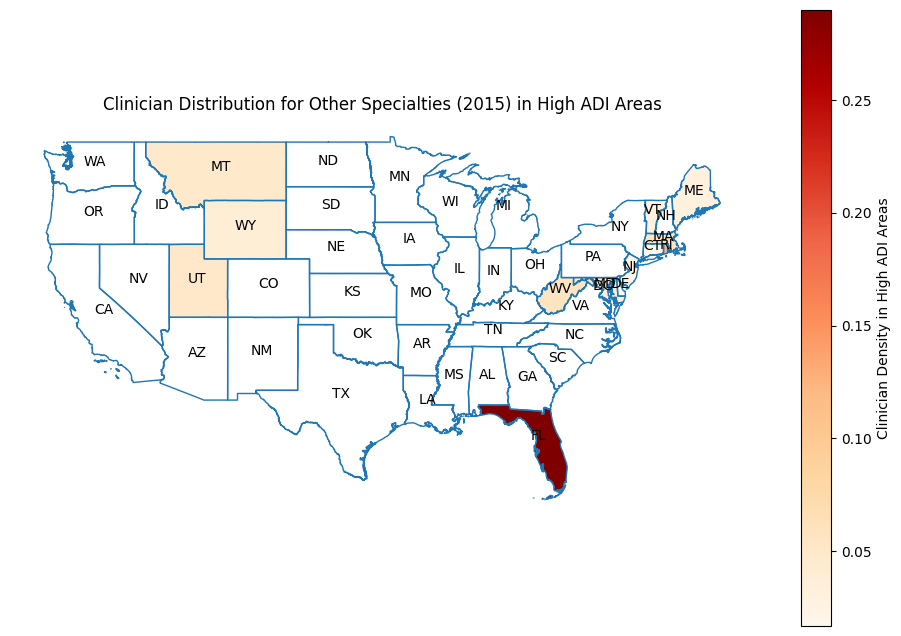

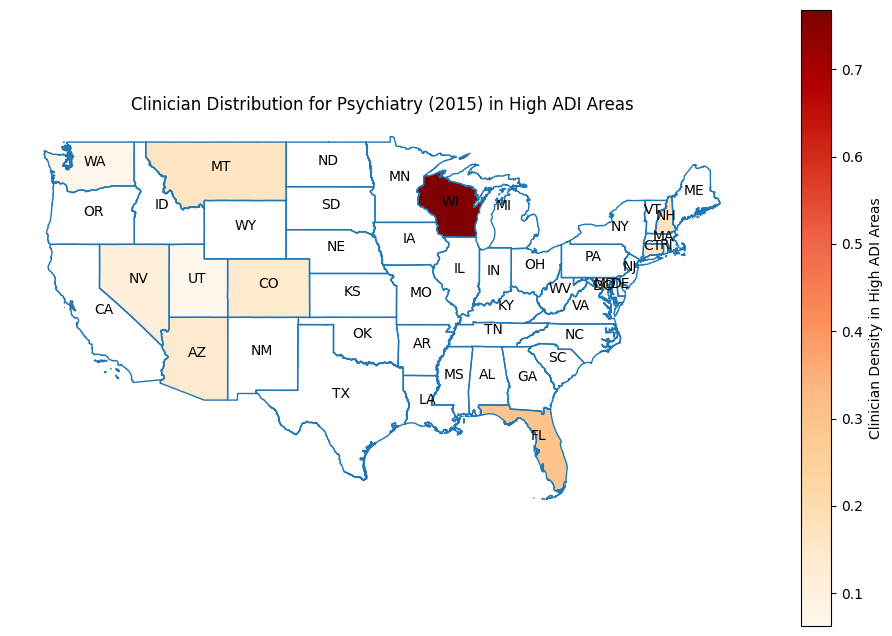

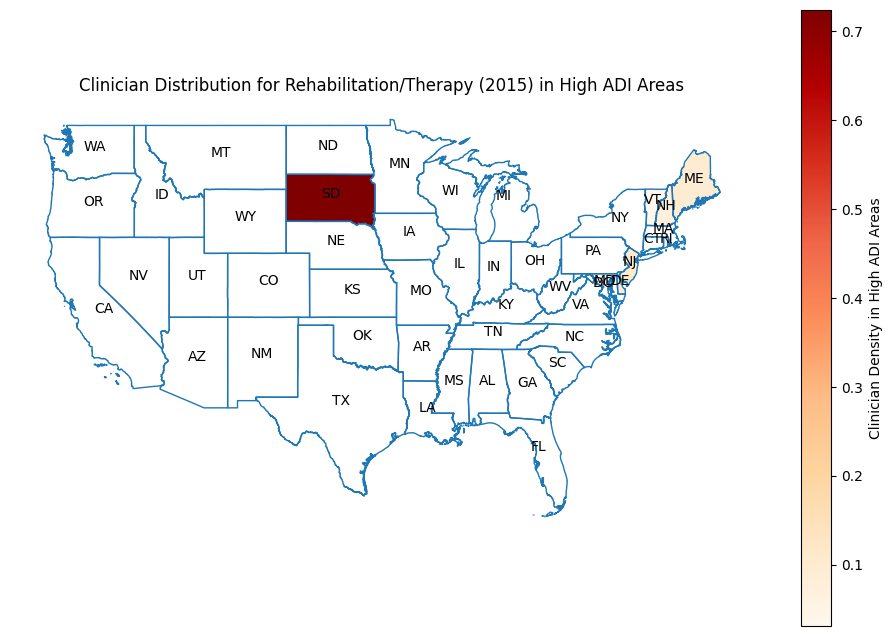

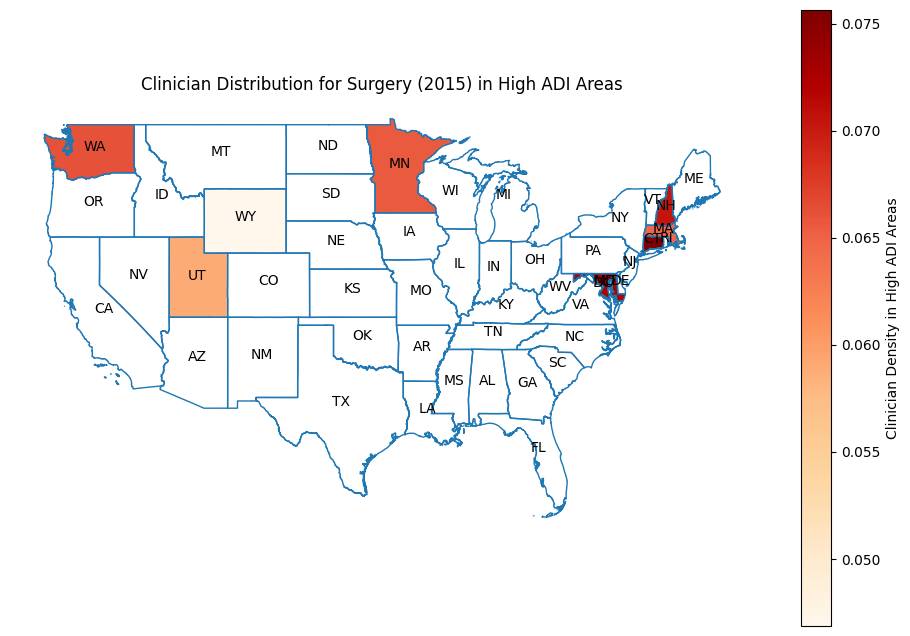

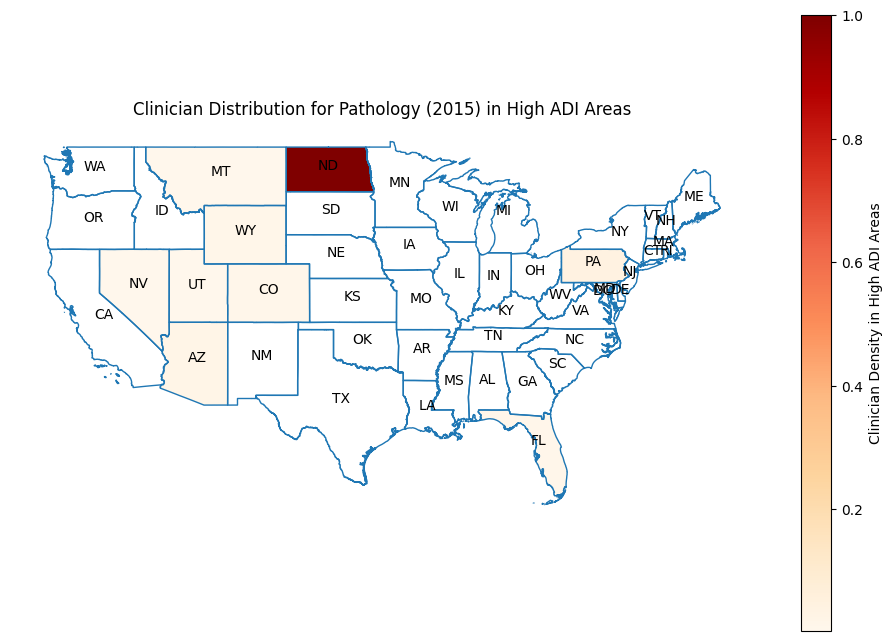

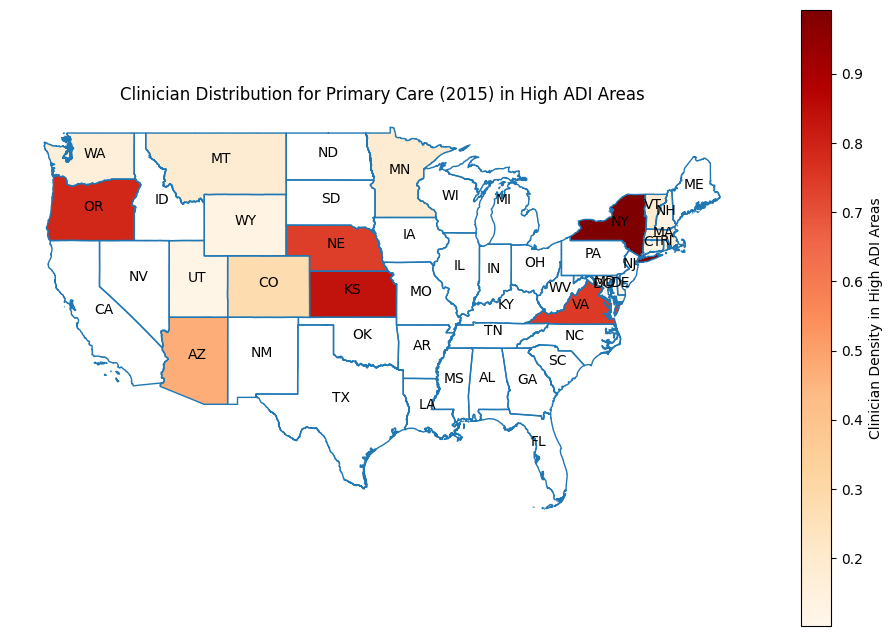

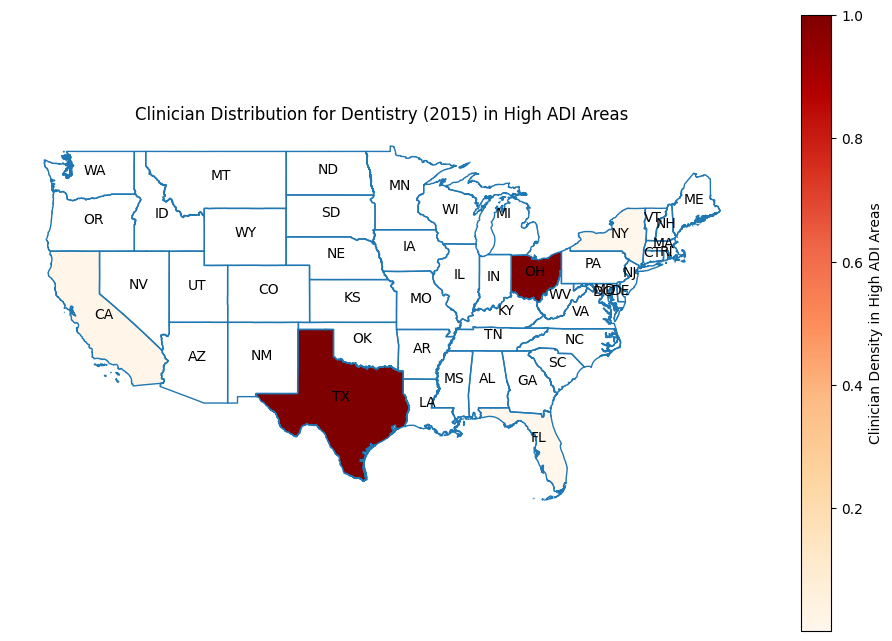

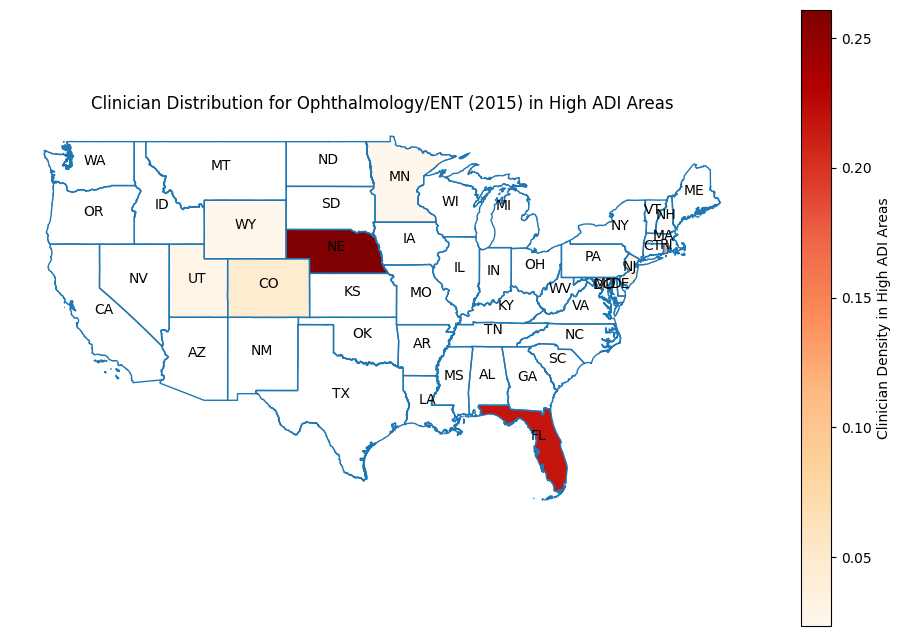

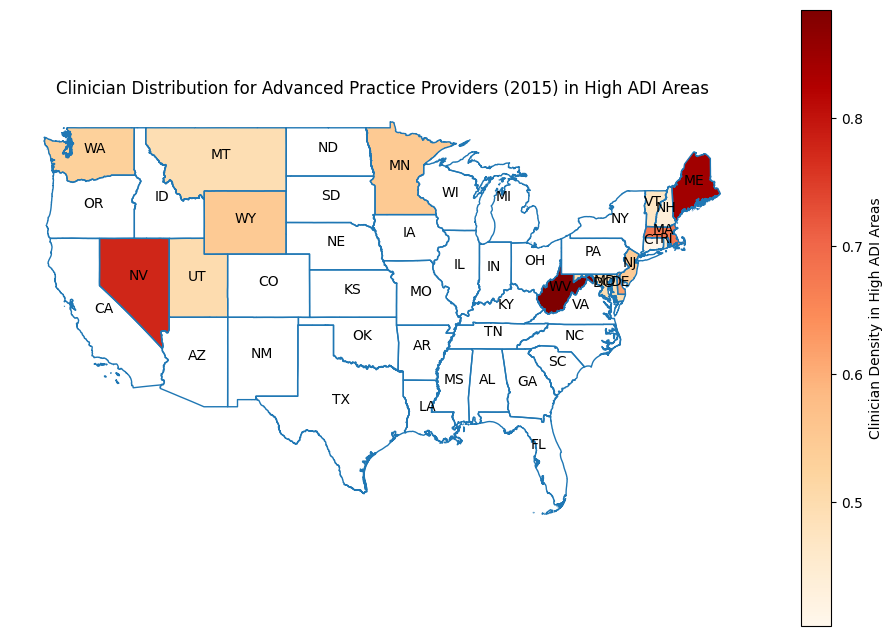

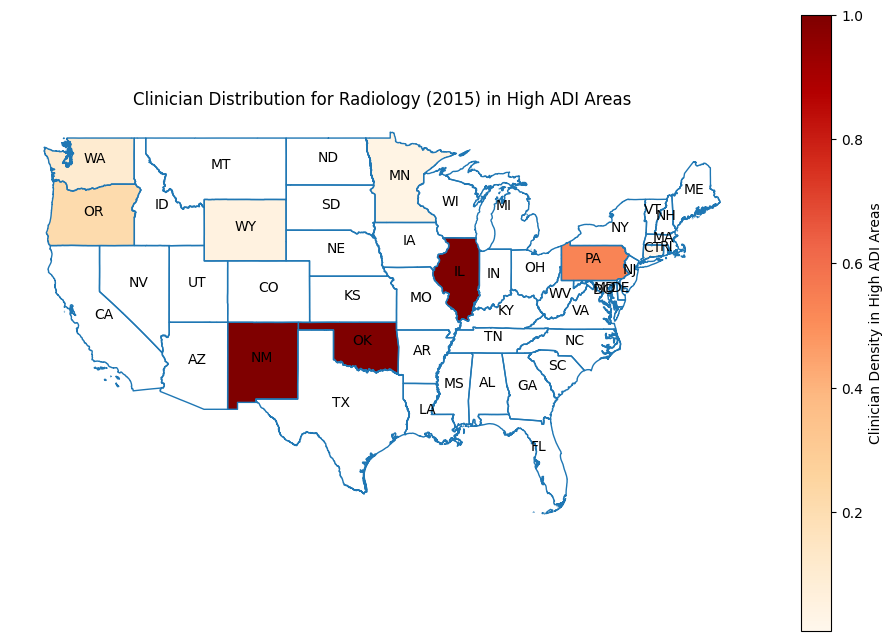

In [ ]:
# Import necessary libraries for geospatial data and plotting
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Download the U.S. states shapefile from the U.S. Census Bureau
us_states_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
us_states = gpd.read_file(us_states_url)

# Filter for mainland U.S. states (excluding island states)
mainland_us_states = us_states[~us_states['STUSPS'].isin(['HI', 'AK', 'AS', 'GU', 'MP', 'PR', 'VI'])]

# Load the medical dataset
file_path = 'updated_medical_population_data.csv'
medical_data = pd.read_csv(file_path)

# Step 1: Filter for 2015 data only
medical_data_2015 = medical_data[medical_data['Grd_yr'] == 2015]

# Step 2: Group by state, specialization, and calculate the normalized clinician percentage by state ADI rank
specialization_grouped = medical_data_2015.groupby(['State', 'pri_spec_grouped']).agg(
    total_clinicians=('ZIP Code', 'count'),  # Assuming each ZIP represents a clinician
    avg_adi_rank=('Avg_ADI_STATERNK_2015', 'mean')
).reset_index()

# Step 3: Normalize the ADI for each state (higher ADI means more deprived)
specialization_grouped['adi_normalized'] = (specialization_grouped['avg_adi_rank'] - specialization_grouped['avg_adi_rank'].min()) / \
                                           (specialization_grouped['avg_adi_rank'].max() - specialization_grouped['avg_adi_rank'].min())

# Step 4: Filter to only focus on high ADI areas (e.g., top 50% ADI)
specialization_grouped_high_adi = specialization_grouped[specialization_grouped['adi_normalized'] >= 0.5]

# Step 5: Normalize clinician count by the total clinicians in each state for high ADI areas
total_clinicians_by_state_high_adi = specialization_grouped_high_adi.groupby('State')['total_clinicians'].sum().reset_index()
specialization_grouped_high_adi = pd.merge(specialization_grouped_high_adi, total_clinicians_by_state_high_adi, on='State', suffixes=('', '_total'))
specialization_grouped_high_adi['clinician_percentage'] = specialization_grouped_high_adi['total_clinicians'] / specialization_grouped_high_adi['total_clinicians_total']

# Step 6: Merge this with the U.S. mainland states shapefile (by state name)
mainland_us_states = mainland_us_states.rename(columns={'STUSPS': 'State'})
merged_data_high_adi = mainland_us_states.merge(specialization_grouped_high_adi, on='State')

# Step 7: Create a function to plot each specialization's map with state labels
def plot_clinicians_map(data, specialization):
    # Filter for a specific specialization
    specialization_data = data[data['pri_spec_grouped'] == specialization]

    # Plotting the map
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    mainland_us_states.boundary.plot(ax=ax, linewidth=1)

    # Plot filled regions with clinician percentage normalized by ADI rank
    specialization_data.plot(column='clinician_percentage', ax=ax, legend=True,
                             cmap='OrRd', legend_kwds={'label': "Clinician Density in High ADI Areas"})

    # Add state labels (CA, NY, etc.)
    for x, y, label in zip(mainland_us_states.geometry.centroid.x, mainland_us_states.geometry.centroid.y, mainland_us_states['State']):
        ax.text(x, y, label, fontsize=10, ha='center', color='black')

    # Add title and adjust plot
    plt.title(f"Clinician Distribution for {specialization} (2015) in High ADI Areas")
    plt.axis('off')
    plt.show()

# Step 8: Plot for each specialization in high ADI areas
unique_specializations = specialization_grouped_high_adi['pri_spec_grouped'].unique()
for spec in unique_specializations:
    plot_clinicians_map(merged_data_high_adi, spec)



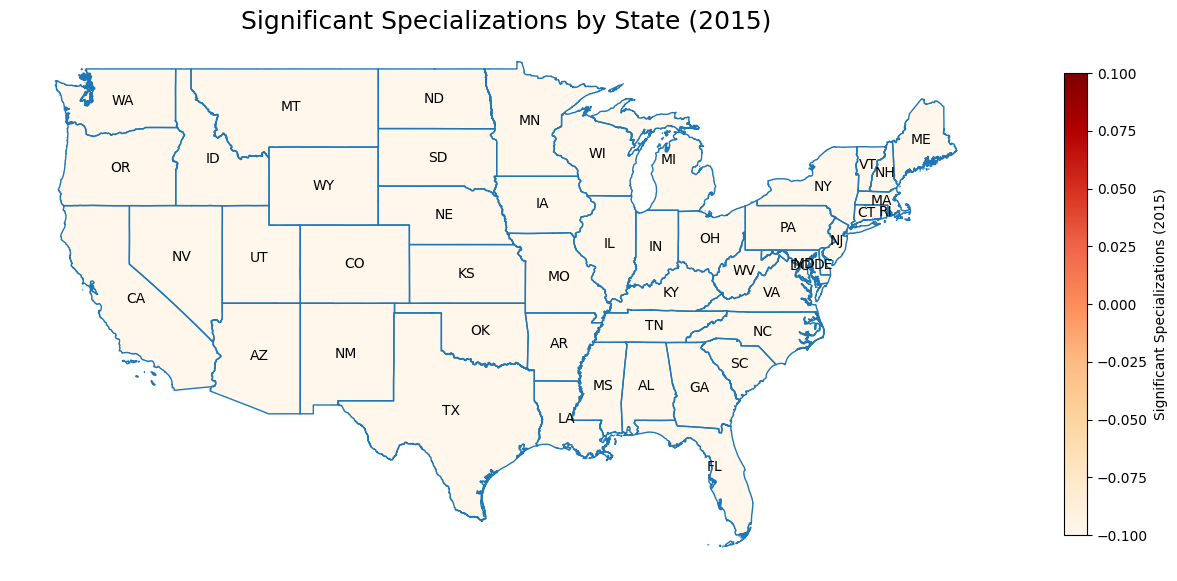

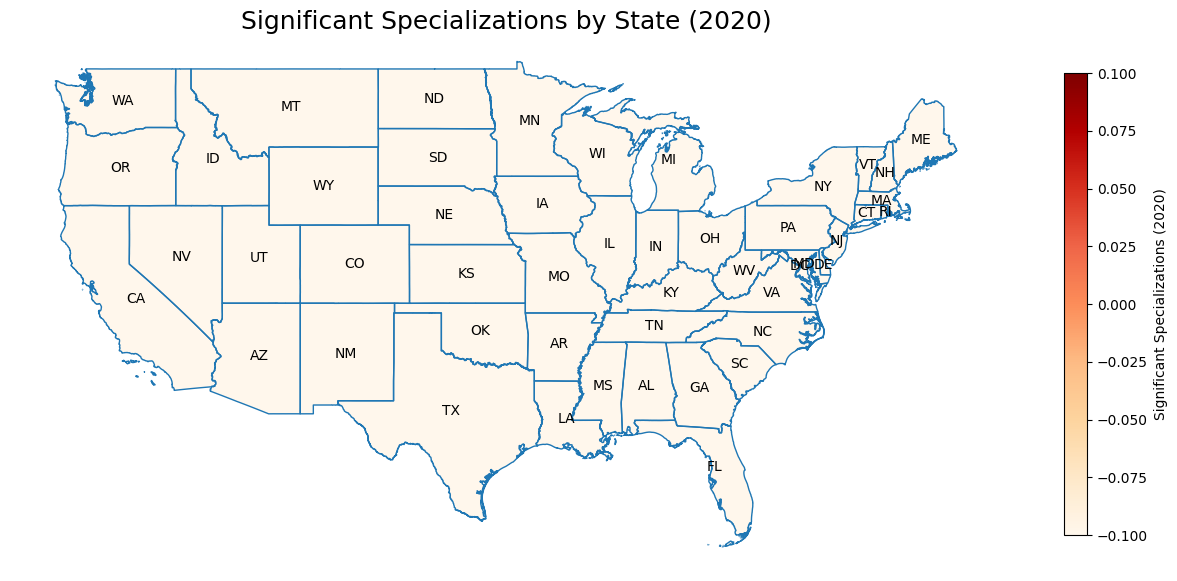

In [ ]:
# Import necessary libraries for geospatial visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Download the U.S. states shapefile from the U.S. Census Bureau
us_states_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
us_states = gpd.read_file(us_states_url)

# Filter for mainland U.S. states (excluding Alaska, Hawaii, and territories)
mainland_us_states = us_states[~us_states['STUSPS'].isin(['HI', 'AK', 'AS', 'GU', 'MP', 'PR', 'VI'])]

# Create DataFrames from the significant specializations counts
sig_spec_2015 = pd.DataFrame(list(significant_specializations_by_state['2015'].items()), columns=['State', 'Count_Specializations_2015'])
sig_spec_2020 = pd.DataFrame(list(significant_specializations_by_state['2020'].items()), columns=['State', 'Count_Specializations_2020'])

# Merge the 2015 and 2020 data with the mainland U.S. shapefile
mainland_us_states = mainland_us_states.rename(columns={'STUSPS': 'State'})
map_data = mainland_us_states.merge(sig_spec_2015, on='State', how='left').merge(sig_spec_2020, on='State', how='left')

# Fill missing values with 0 (for states with no significant specializations)
map_data['Count_Specializations_2015'] = map_data['Count_Specializations_2015'].fillna(0)
map_data['Count_Specializations_2020'] = map_data['Count_Specializations_2020'].fillna(0)

# Add state centroids for labeling
map_data['centroid'] = map_data.geometry.centroid

# Adjusted plot for 2015 with a vertical color bar and state labels
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plotting the boundaries of mainland U.S. states
mainland_us_states.boundary.plot(ax=ax, linewidth=1)

# Plotting the map data with vertical color bar
map_data.plot(column='Count_Specializations_2015', ax=ax, legend=True, cmap='OrRd',
              legend_kwds={'label': "Significant Specializations (2015)", 'orientation': "vertical", 'shrink': 0.6})

# Adding state labels (centered in each state)
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['State']):
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

# Setting the title and removing axes
ax.set_title("Significant Specializations by State (2015)", fontsize=18)
plt.axis('off')

plt.show()


# Adjusted plot for 2015 with a vertical color bar and state labels
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plotting the boundaries of mainland U.S. states
mainland_us_states.boundary.plot(ax=ax, linewidth=1)

# Plotting the map data with vertical color bar
map_data.plot(column='Count_Specializations_2020', ax=ax, legend=True, cmap='OrRd',
              legend_kwds={'label': "Significant Specializations (2020)", 'orientation': "vertical", 'shrink': 0.6})

# Adding state labels (centered in each state)
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['State']):
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

# Setting the title and removing axes
ax.set_title("Significant Specializations by State (2020)", fontsize=18)
plt.axis('off')

plt.show()

